## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Ира Букреева

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

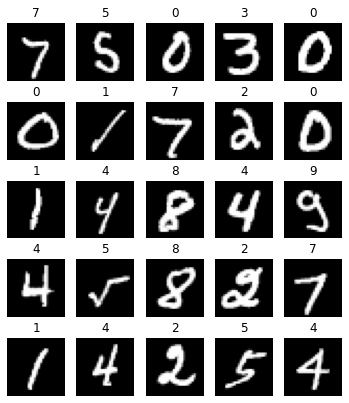

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [12]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

def He_Goodgrads(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)

def He_Goodweights(size_input, size_output):
    d = 2 / size_input
    return np.sqrt(d)

#init_func = normal
#init_func = xavier
init_func = He_Goodgrads
#init_func = He_Goodweights
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [13]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0197032690048218
forward 2.888136386871338
forward 3.716503858566284
forward 5.350535869598389
forward 5.992465972900391
forward 5.703779697418213
forward 3.218958854675293
forward 2.8949153423309326
forward 3.2851061820983887
forward 2.9422945976257324
forward 2.4993436336517334
forward 2.099663257598877
forward 1.6343046426773071
forward 2.1060400009155273
forward 2.6527886390686035
forward 2.44362473487854
forward 1.8923152685165405
forward 2.225604295730591
forward 2.5807249546051025
forward 2.440776824951172
forward 1.4750747680664062
forward 1.9378286600112915
forward 1.6080554723739624
forward 1.4835575819015503
forward 1.2424153089523315
forward 0.6261883974075317
forward 0.6101346015930176
forward 0.7028748989105225
forward 0.649771511554718
forward 0.3999553322792053
forward 0.40796738862991333
forward 0.2003554403781891
forward 0.20115427672863007
backward 0.04807402193546295
backward 0.1418885588645935
backward 0.17270886898040771
backward 0.16473373770713806
back

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

<i> 1.4 Сделайте выводы по первой части </i>

Убедились, что правильная инициализация весов значительно улучшает сходимость сети

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [14]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейронных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [15]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [16]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.134/0.281	Accuracy: 0.959/0.974


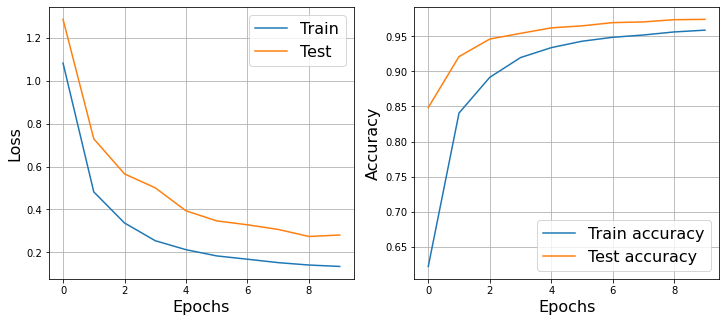

CPU times: user 1min 56s, sys: 1.9 s, total: 1min 58s
Wall time: 2min 4s


In [18]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.118/0.279	Accuracy: 0.963/0.974


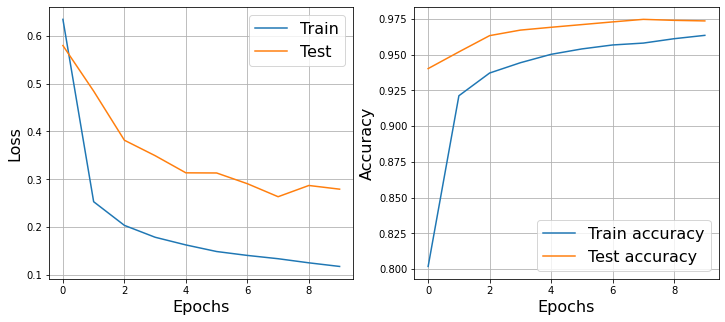

CPU times: user 1min 51s, sys: 423 ms, total: 1min 52s
Wall time: 1min 52s


In [19]:
%%time

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.094/0.219	Accuracy: 0.971/0.981


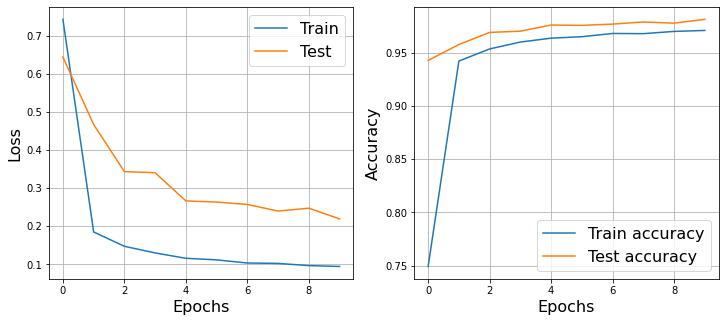

CPU times: user 1min 49s, sys: 440 ms, total: 1min 49s
Wall time: 1min 49s


In [20]:
%%time

#dropconnect
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

убедились, что Dropout и DropConnect уменьшают переобучение. На test скор даже ниже, чем на train

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [77]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
      # shape: 128*n
        mean = x.mean(axis=1, keepdim=True)
        std = x.std(axis=1, keepdim=True)
        output = (x-mean)/(std)
        
        return output

<i> 
3.2 Сравните графики обучения нейронных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [79]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    #layer = LayerNormalization()
    
    layers.append(layer)
    layers.append(nn.BatchNorm1d(size_output))
    layers.append(nn.ReLU())

del layers[-1]
layers

[Linear(in_features=196, out_features=256, bias=True),
 BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 Linear(in_features=256, out_features=128, bias=True),
 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 Linear(in_features=128, out_features=10, bias=True),
 BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

Epoch 9... (Train/Test) NLL: 0.032/0.054	Accuracy: 0.993/0.984


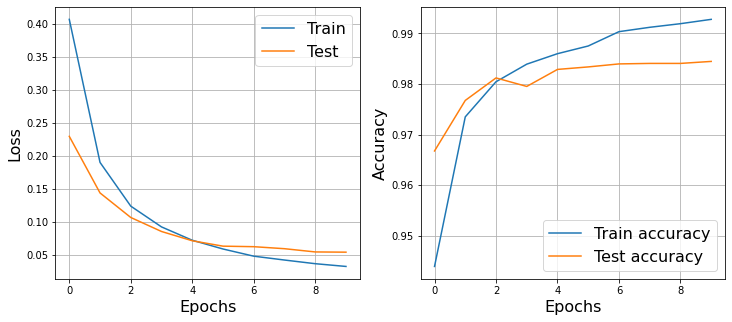

CPU times: user 1min 43s, sys: 438 ms, total: 1min 44s
Wall time: 1min 44s


In [80]:
%%time

#BatchNorm
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

In [81]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    layers.append(LayerNormalization())
    layers.append(nn.ReLU())

del layers[-1]
layers

[Linear(in_features=196, out_features=256, bias=True),
 LayerNormalization(),
 ReLU(),
 Linear(in_features=256, out_features=128, bias=True),
 LayerNormalization(),
 ReLU(),
 Linear(in_features=128, out_features=10, bias=True),
 LayerNormalization()]

Epoch 9... (Train/Test) NLL: 0.347/0.362	Accuracy: 0.992/0.985


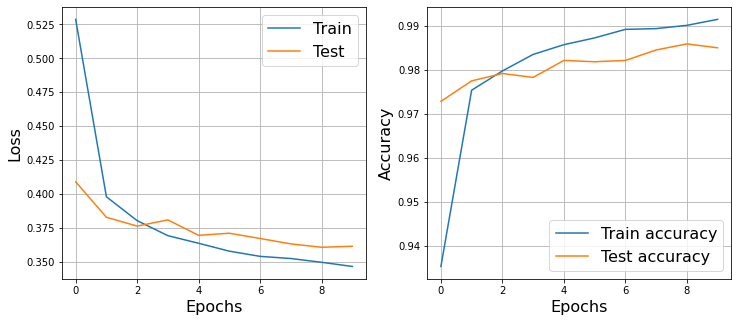

CPU times: user 1min 42s, sys: 400 ms, total: 1min 42s
Wall time: 1min 43s


In [82]:
%%time

#LayerNorm
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

Кажется, что BatchNorm работает не очень стабильно и результаты зависят от батчей. C LayerNorm скор получился такой же